In [ ]:
# First will import the dataframe created previously containing the features of the bird song and some metadata for each clip
import pandas as pd
data = pd.read_csv('data_dropped')

In [ ]:
data.English_name.value_counts()

Yellowhammer             1000
Eurasian Skylark         1000
Stock Dove               1000
Eurasian Tree Sparrow    1000
Common Whitethroat       1000
Common Linnet            1000
European Goldfinch       1000
Common Starling          1000
Northern Lapwing         1000
Corn Bunting             1000
European Turtle Dove     1000
Grey Partridge           1000
Name: English_name, dtype: int64

Data is perfectly balanced between bird species so no need to do anything with balancing here at this time. 

### Setting Labels 
The following section creates a column called label in the DataFrame and assigns a numerical value for each bird. 

This is done as some model require the labels to be supplied as numerical values. 

In [ ]:
data['label'] = data.English_name

In [ ]:
data.label.replace(value=0, to_replace ="Yellowhammer", inplace=True)
data.label.replace(value=1, to_replace ="Eurasian Skylark", inplace=True)
data.label.replace(value=2, to_replace ="Stock Dove", inplace=True)
data.label.replace(value=3, to_replace ="Eurasian Tree Sparrow", inplace=True)
data.label.replace(value=4, to_replace ="Common Whitethroat", inplace=True)
data.label.replace(value=5, to_replace ="Common Linnet", inplace=True)
data.label.replace(value=6, to_replace ="European Goldfinch", inplace=True)
data.label.replace(value=7, to_replace ="Common Starling", inplace=True)
data.label.replace(value=8, to_replace ="Northern Lapwing", inplace=True)
data.label.replace(value=9, to_replace ="Corn Bunting", inplace=True)
data.label.replace(value=10, to_replace ="European Turtle Dove", inplace=True)
data.label.replace(value=11, to_replace ="Grey Partridge", inplace=True)

The features and labels are then seperated out into features the model will be trained on (contained in data_num DataFrame) and labels (contained in data_labels pandas Series).

In [ ]:
data_num = data.iloc[:,1:137]
data_labels = data.label

### PCA
The each clip of bird song contains 136 features, as we do not know what the important features are, principal component analysis was conducted on the features set for dimension reduction, which should retain most of the variability in the data but will reduce computational cost.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(data_num)
data_num = scaler.transform(data_num)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)    # The amount of varibility from the original data to retain can be varied
pca.fit(data_num)
pca_components = pca.n_components_

In [ ]:
pca_components # shows how many principal components are retained to keep to original variability

91

In [ ]:
data_num = pca.transform(data_num)

### Train, Validation, Test Split

Data is then split into train, validation and test sets in proportion 60:20:20

In [ ]:
for i in range(len(data_num)):
  if i == 0:
    X_train = np.array(data_num[i])  # features saved into X variables
    y_train = np.array(data_labels[i]) # labels saved into y variables
    continue
  if i == 3:
    X_valid = np.array(data_num[i])
    y_valid = np.array(data_labels[i])
    continue
  if i == 4:
    X_test = np.array(data_num[i])
    y_test = np.array(data_labels[i])
    continue
  
  if i%5 < 3:
    X_train = np.vstack((X_train, data_num[i]))
    y_train = np.vstack((y_train, data_labels[i]))

  if i%5 == 3:
    X_valid = np.vstack((X_valid, data_num[i]))
    y_valid = np.vstack((y_valid, data_labels[i]))

  if i%5 == 4:
    X_test = np.vstack((X_test, data_num[i]))
    y_test = np.vstack((y_test, data_labels[i]))

y_train, y_valid, y_test = y_train.flatten(), y_valid.flatten(), y_test.flatten() # y variables flattened as scikit learn classifiers require a one dimensional array for labels. 

In [ ]:
# Results DataFrames created these will be used for evualtion of models. 

valid_results = pd.DataFrame()
valid_results["labels"] = y_valid
test_results = pd.DataFrame()
test_results["labels"] = y_test

# Models

### Support Vector Machine

In [ ]:
from sklearn import svm
from time import time
training_time = {}
t0 = time()
clf = svm.SVC(gamma = 'auto', class_weight = 'balanced', kernel = 'rbf', C = 15).fit(X_train, y_train)
ttime = time() - t0
training_time['SVM'] = ttime # training time calcualted and added to training time dictionary
valid_results["SVM_preds"] = clf.predict(X_valid)
# SVM model trained on training data
# Vaidation data then ran through the model and predictions added to results DataFrame

# Accuracy taken from 
print("Accuracy of SVM on validation set:", round(100*(sum(valid_results.labels == valid_results.SVM_preds)/len(valid_results)), 2), "%")

Accuracy of SVM on validation set: 70.21 %


### Nearest Neighbour

In [ ]:
from sklearn.neighbors import NearestCentroid

t0 = time()
clf = NearestCentroid().fit(X_train, y_train)
ttime = time() - t0
training_time['Nearest Neighbours'] = ttime 
valid_results["NN_preds"] = clf.predict(X_valid)

print("Accuracy of Nearest Neighbour on validation set:", round(100*(sum(valid_results.labels == valid_results.NN_preds)/len(valid_results)), 2), "%")

Accuracy of Nearest Neighbour on validation set: 34.5 %


### Decision Trees

In [ ]:
from sklearn import tree

t0 = time()
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
ttime = time() - t0
training_time['Decision Tree'] = ttime
valid_results["DT_preds"] = clf.predict(X_valid)

print("Accuracy of Decision Tree on validation set:", round(100*(sum(valid_results.labels == valid_results.DT_preds)/len(valid_results)), 2), "%")

Accuracy of Decision Tree on validation set: 35.38 %


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

t0 = time()
clf = RandomForestClassifier(n_estimators = 500).fit(X_train, y_train)
ttime = time() - t0
training_time['Random Forest'] = ttime
valid_results["RF_preds"] = clf.predict(X_valid)

print("Accuracy of Random Forest on validation set:", round(100*(sum(valid_results.labels == valid_results.RF_preds)/len(valid_results)), 2), "%")

Accuracy of Random Forest on validation set: 60.92 %


### Extra Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

t0 = time()
clf = ExtraTreesClassifier(criterion = 'gini', max_features = 'sqrt', n_estimators=500, max_depth=None, min_samples_split=3, random_state=0).fit(X_train, y_train)
ttime = time() - t0
training_time['Extra Trees'] = ttime
valid_results["ETrees_preds"] = clf.predict(X_valid)

print("Accuracy of Extra Trees on validation set:", round(100*(sum(valid_results.labels == valid_results.ETrees_preds)/len(valid_results)), 2), "%")


Accuracy of Extra Trees on validation set: 65.62 %


### Neural Network
However, neural network from PyTorch package requires inputs and outputs in different forms than Scikit Learn so will take the data from just after the PCA stage and add it to train, validation and testset and then DataLoader before training the network.

In [ ]:
import torch
# Similarily to the scikit learn models the data is split into train, validation and testsets in ratio 60:20:20
# Each set is a list of tuples, with each tuple containing a tensor of the inputs and a tensor of the label. 
trainset, validset, testset = [], [], []
data_labels_test = []

for i in range(len(data_num)):
  if i%5 < 3:
    trainset.append((torch.from_numpy(data_num[i]).float(), torch.tensor(data_labels[i]).long()))
  if i%5 == 4:
    validset.append((torch.from_numpy(data_num[i]).float(), torch.tensor(data_labels[i]).long()))
  if i%5 == 3:
    testset.append((torch.from_numpy(data_num[i]).float(), torch.tensor(data_labels[i]).long()))
    data_labels_test.append(data_labels[i])


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16 # Batch size can be varied

# The train, validation and test sets are then put into a DataLoader which can be iterated through
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# A fully connected neural network is created 

class model(nn.Module):

  def __init__(self, inputs = pca_components):
    super(model, self).__init__()

    self.inputs = inputs
    self.fc1 = nn.Linear(self.inputs, 100)
    self.fc2 = nn.Linear(100, 300)
    self.fc3 = nn.Linear(300, 150)
    self.fc4 = nn.Linear(150, 12)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x) 

    return F.softmax(x, dim=1)

model = model()

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to trainin neural network. 

# Dataloader containing trainset is ran through model and loss is calcualted for each batch during forward pass. 
# Back propagation is then used to update the weights in the models. 

def train_network(model, trainloader, validloader, learning_rate = 1e-5, num_epochs = 100, weight_decay = 0.001):

    t0 = time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    losses, train_acc, valid_acc = [], [], []
    epochs = []


    for epoch in tqdm(range(num_epochs)):
      correct = 0
      total = 0
      
      for input, label in trainloader:
          
          #forward pass
          optimizer.zero_grad()
          out = model(input)
          loss = criterion(out, label)
          
          #back propagation
          loss.backward()
          optimizer.step()            
            
      losses.append(float(loss))     
      if epoch % 5 == 4:
          epochs.append(epoch)
          train_acc.append(cal_acc(model, trainloader))
          valid_acc.append(cal_acc(model, validloader))


    # plotting the accuracy of the model on training and vaildation sets during training of network
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    ttime_NN = time() - t0
    print("Training time:", ttime_NN, "seconds")
    return ttime_NN

# Fucntion used to calculate the accuracy of the model
# Grabs each prediction and if it matches with the label adds one to correct count
# Adds one to total counts for each prediction
# Returns the correct / total counts
def cal_acc(model, dataloader):
  correct, total = 0, 0
  with torch.no_grad():
    for input, label in dataloader:
      out = model(input)
      pred = torch.max(out, 1)
      for i in range(len(label)):
        if out[i].argmax() == label[i]:
          correct += 1
        total += 1
  return correct / total

# Fucntion used to calculate the accuracy of the model on the test set.
# Works similarily to the cal_acc function but holds a seperate correct and total count for each potential output (bird species)
# This means it can return a seperate accuracy for each individual bird species as well as overall model accuracy.
def cal_test_acc(model, dataloader):
  results = pd.DataFrame()
  results['label'] = data_labels_test
  preds, labels = [], []
  cor0, cor1, cor2, cor3, cor4, cor5, cor6, cor7, cor8, cor9, cor10, cor11 = 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  tot0, tot1, tot2, tot3, tot4, tot5, tot6, tot7, tot8, tot9, tot10, tot11 = 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  correct, total = 0, 0
  with torch.no_grad():
    for input, label in dataloader:
      out = model(input)
      _, pred = torch.max(out, 1)            
      for i in range(len(pred)):
        if pred[i] == label[i]:
          correct += 1
        if label[i] == 0:
          tot0 += 1
          if pred[i] == label[i]:
            cor0 += 1
        if label[i] == 1:
          tot1 += 1
          if pred[i] == label[i]:
            cor1 += 1
        if label[i] == 2:
          tot2 += 1
          if pred[i] == label[i]:
            cor2 += 1
        if label[i] == 3:
          tot3 += 1
          if pred[i] == label[i]:
            cor3 += 1
        if label[i] == 4:
          tot4 += 1
          if pred[i] == label[i]:
            cor4 += 1
        if label[i] == 5:
          tot5 += 1
          if pred[i] == label[i]:
            cor5 += 1
        if label[i] == 6:
          tot6 += 1
          if pred[i] == label[i]:
            cor6 += 1
        if label[i] == 7:
          tot7 += 1
          if pred[i] == label[i]:
            cor7 += 1
        if label[i] == 8:
          tot8 += 1
          if pred[i] == label[i]:
            cor8 += 1
        if label[i] == 9:
          tot9 += 1
          if pred[i] == label[i]:
            cor9 += 1
        if label[i] == 10:
          tot10 += 1
          if pred[i] == label[i]:
            cor10 += 1
        if label[i] == 11:
          tot11 += 1
          if pred[i] == label[i]:
            cor11 += 1
        total += 1
        preds.append(pred[i].item())
  results['preds'] = preds
  results.replace(to_replace=0, value="Yellowhammer", inplace=True)
  results.replace(to_replace=1, value="Eurasian Skylark", inplace=True)
  results.replace(to_replace=2, value="Stock Dove", inplace=True)
  results.replace(to_replace=3, value="Eurasian Tree Sparrow", inplace=True)
  results.replace(to_replace=4, value="Common Whitethroat", inplace=True)
  results.replace(to_replace=5, value="Common Linnet", inplace=True)
  results.replace(to_replace=6, value="European Goldfinch", inplace=True)
  results.replace(to_replace=7, value="Common Starling", inplace=True)
  results.replace(to_replace=8, value="Northern Lapwing", inplace=True)
  results.replace(to_replace=9, value="Corn Bunting", inplace=True)
  results.replace(to_replace=10, value="European Turtle Dove", inplace=True)
  results.replace(to_replace=11, value="Grey Partridge", inplace=True)

  return results, correct / total, cor0/tot0, cor1/tot1, cor2/tot2, cor3/tot3, cor4/tot4, cor5/tot5, cor6/tot6, cor7/tot7, cor8/tot8, cor9/tot9, cor10/tot10, cor11/tot11 

100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


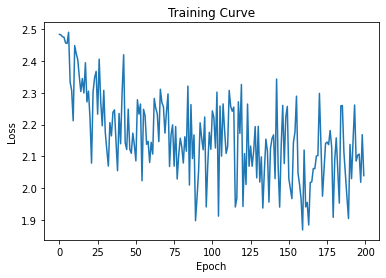

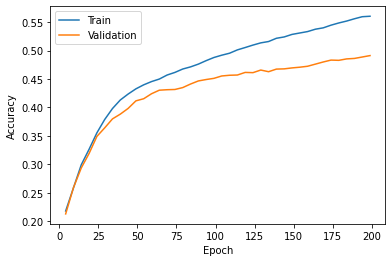

Training time: 157.73795890808105 seconds


In [ ]:
ttime_NN = train_network(model, trainloader, validloader, num_epochs=200)

In [ ]:
# Gets results from running testset through neural network and printing overall accuracy and accuracy for each bird. 

results, test_acc, acc0, acc1, acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9, acc10, acc11 = cal_test_acc(model, testloader)
print("Final test accuracy:", round(100*test_acc, 1), "%")
print("Yellowhammer accuracy:", round(100*acc0, 1), "%")
print("Eurasian Skylark accuracy:", round(100*acc1, 1), "%")
print("Stock Dove accuracy:", round(100*acc2, 1), "%")
print("Eurasian Tree Sparrow accuracy:", round(100*acc3, 1), "%")
print("Common Whitethroat accuracy:", round(100*acc4, 1), "%")
print("Common Linnet accuracy:", round(100*acc5, 1), "%")
print("European Goldfinch accuracy:", round(100*acc6, 1), "%")
print("Common Starling accuracy:", round(100*acc7, 1), "%")
print("Northern Lapwing accuracy:", round(100*acc8, 1), "%")
print("Corn Bunting accuracy:", round(100*acc9, 1), "%")
print("European Turtle Dove accuracy:", round(100*acc10, 1), "%")
print("Grey Partridge accuracy:", round(100*acc11, 1), "%")

Final test accuracy: 50.0 %
Yellowhammer accuracy: 55.8 %
Eurasian Skylark accuracy: 0.0 %
Stock Dove accuracy: 72.1 %
Eurasian Tree Sparrow accuracy: 47.5 %
Common Whitethroat accuracy: 15.0 %
Common Linnet accuracy: 49.2 %
European Goldfinch accuracy: 25.1 %
Common Starling accuracy: 63.5 %
Northern Lapwing accuracy: 76.2 %
Corn Bunting accuracy: 46.3 %
European Turtle Dove accuracy: 84.8 %
Grey Partridge accuracy: 62.8 %


# Results

Prints overall accuarcy for each model

In [ ]:
print("Accuracy of SVM on validation set:", round(100*(sum(valid_results.labels == valid_results.SVM_preds)/len(valid_results)), 2), "%")
print("Accuracy of Nearest Neighbour on validation set:", round(100*(sum(valid_results.labels == valid_results.NN_preds)/len(valid_results)), 2), "%")
print("Accuracy of Decision Tree on validation set:", round(100*(sum(valid_results.labels == valid_results.DT_preds)/len(valid_results)), 2), "%")
print("Accuracy of Random Forest on validation set:", round(100*(sum(valid_results.labels == valid_results.RF_preds)/len(valid_results)), 2), "%")
print("Accuracy of Extra Trees on validation set:", round(100*(sum(valid_results.labels == valid_results.ETrees_preds)/len(valid_results)), 2), "%")
print("Accuracy of Neural Network on validation set:", round(100*test_acc, 2), "%")

Accuracy of SVM on validation set: 70.21 %
Accuracy of Nearest Neighbour on validation set: 34.5 %
Accuracy of Decision Tree on validation set: 35.38 %
Accuracy of Random Forest on validation set: 60.92 %
Accuracy of Extra Trees on validation set: 65.62 %
Accuracy of Neural Network on validation set: 49.96 %


Prints training time for each model

In [ ]:
for model in training_time:
  print("Training time", model, "is:", round(training_time[model], 2), "seconds.")
print("Training time Neural Network is:", round(ttime_NN, 2), "seconds.")

Training time SVM is: 7.55 seconds.
Training time Nearest Neighbours is: 0.01 seconds.
Training time Decision Tree is: 1.19 seconds.
Training time Random Forest is: 36.89 seconds.
Training time Extra Trees is: 9.47 seconds.
Training time Neural Network is: 157.74 seconds.


Adding all results from validation set to DataFrame so they can be quickly and easily compared

In [ ]:
import tabulate

model_comparison = pd.DataFrame()
models = ['Support Vector Machine', 'Nearest Neighbours', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Neural Network']
accuracy = [round(100*(sum(valid_results.labels == valid_results.SVM_preds)/len(valid_results)), 2),
            round(100*(sum(valid_results.labels == valid_results.NN_preds)/len(valid_results)), 2),
            round(100*(sum(valid_results.labels == valid_results.DT_preds)/len(valid_results)), 2),
            round(100*(sum(valid_results.labels == valid_results.RF_preds)/len(valid_results)), 2),
            round(100*(sum(valid_results.labels == valid_results.ETrees_preds)/len(valid_results)), 2),
            round(100*test_acc, 2)
            ]
train_time = []
for model in training_time:
  train_time.append(round(training_time[model], 2))
train_time.append(round(ttime_NN, 2))

model_comparison['Model'], model_comparison['Accuracy (%)'], model_comparison['Training Time (s)'] = models, accuracy, train_time
model_comparison.to_csv('model_comparison')
model_comparison

,Model,Accuracy (%),Training Time (s)
0,Support Vector Machine,70.21,7.55
1,Nearest Neighbours,34.50,0.01
2,Decision Tree,35.38,1.19
3,Random Forest,60.92,36.89
4,Extra Trees,65.62,9.47
5,Neural Network,49.96,157.74


SVM was found to return the best results.
Here is a further breakdown of the accuracy of the SVM model for each bird species. 



In [ ]:
correctSVM = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
totalSVM = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}

for index, row in valid_results.iterrows():
  totalSVM[row['labels']] += 1
  if row['labels'] == row['SVM_preds']:
    correctSVM[row['labels']] += 1
  
print("-"*10, "Accuracy for SVM", "-"*10)
print("Overall Accuracy:", round(100*(sum(valid_results.labels == valid_results.SVM_preds)/len(valid_results)), 2), "%")
print("")
print("Yellowhammer accuracy:", round(100*correctSVM[0]/totalSVM[0], 1), "%")
print("Eurasian Skylark accuracy:", round(100*correctSVM[1]/totalSVM[1], 1), "%")
print("Stock Dove accuracy:", round(100*correctSVM[2]/totalSVM[2], 1), "%")
print("Eurasian Tree Sparrow accuracy:", round(100*correctSVM[3]/totalSVM[3], 1), "%")
print("Common Whitethroat accuracy:", round(100*correctSVM[4]/totalSVM[4], 1), "%")
print("Common Linnet accuracy:", round(100*correctSVM[5]/totalSVM[5], 1), "%")
print("European Goldfinch accuracy:", round(100*correctSVM[6]/totalSVM[6], 1), "%")
print("Common Starling accuracy:", round(100*correctSVM[7]/totalSVM[7], 1), "%")
print("Northern Lapwing accuracy:", round(100*correctSVM[8]/totalSVM[8], 1), "%")
print("Corn Bunting accuracy:", round(100*correctSVM[9]/totalSVM[9], 1), "%")
print("European Turtle Dove accuracy:", round(100*correctSVM[10]/totalSVM[10], 1), "%")
print("Grey Partridge accuracy:", round(100*correctSVM[11]/totalSVM[11], 1), "%")

---------- Accuracy for SVM ----------
Overall Accuracy: 70.21 %

Yellowhammer accuracy: 68.0 %
Eurasian Skylark accuracy: 52.3 %
Stock Dove accuracy: 86.8 %
Eurasian Tree Sparrow accuracy: 69.5 %
Common Whitethroat accuracy: 57.0 %
Common Linnet accuracy: 61.9 %
European Goldfinch accuracy: 52.7 %
Common Starling accuracy: 73.1 %
Northern Lapwing accuracy: 81.7 %
Corn Bunting accuracy: 65.9 %
European Turtle Dove accuracy: 93.4 %
Grey Partridge accuracy: 80.1 %


#Here is the final results on the previously unseen testset data

In [ ]:
correctSVM = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
totalSVM = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
accSVM = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}


test_results["SVM_preds"] = clf.predict(X_test)

for index, row in test_results.iterrows():
  totalSVM[row['labels']] += 1
  if row['labels'] == row['SVM_preds']:
    correctSVM[row['labels']] += 1

for key in correctSVM:
  accSVM[key] = round(100 * correctSVM[key] / totalSVM[key], 1)



  
print("-"*10, "Accuracy for SVM Testset", "-"*10)
print("Overall Accuracy:", round(100*(sum(test_results.labels == test_results.SVM_preds)/len(test_results)), 2), "%")
print("")
print("Yellowhammer accuracy:", accSVM[0], "%")
print("Eurasian Skylark accuracy:", accSVM[1], "%")
print("Stock Dove accuracy:", accSVM[2], "%")
print("Eurasian Tree Sparrow accuracy:", accSVM[3], "%")
print("Common Whitethroat accuracy:", accSVM[4], "%")
print("Common Linnet accuracy:", accSVM[5], "%")
print("European Goldfinch accuracy:", accSVM[6], "%")
print("Common Starling accuracy:", accSVM[7], "%")
print("Northern Lapwing accuracy:", accSVM[8], "%")
print("Corn Bunting accuracy:", accSVM[9], "%")
print("European Turtle Dove accuracy:", accSVM[10], "%")
print("Grey Partridge accuracy:", accSVM[11], "%")

---------- Accuracy for SVM Testset ----------
Overall Accuracy: 69.29 %

Yellowhammer accuracy: 66.3 %
Eurasian Skylark accuracy: 54.4 %
Stock Dove accuracy: 85.3 %
Eurasian Tree Sparrow accuracy: 73.1 %
Common Whitethroat accuracy: 53.5 %
Common Linnet accuracy: 64.3 %
European Goldfinch accuracy: 53.4 %
Common Starling accuracy: 78.5 %
Northern Lapwing accuracy: 81.1 %
Corn Bunting accuracy: 57.4 %
European Turtle Dove accuracy: 87.2 %
Grey Partridge accuracy: 77.9 %


Plotting breakdown by species

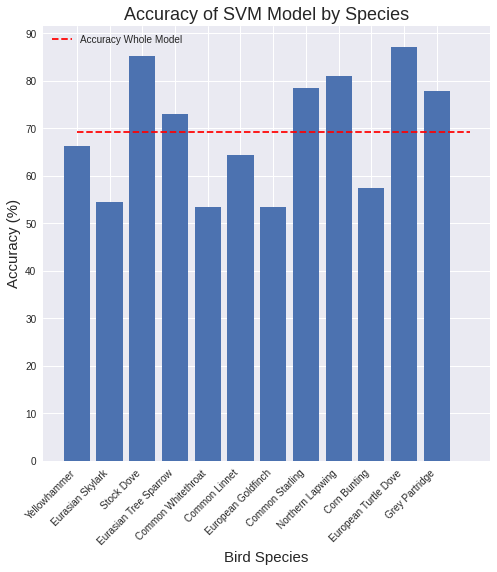

In [ ]:
birds = ['Yellowhammer',
         'Eurasian Skylark',
         'Stock Dove',
         'Eurasian Tree Sparrow',
         'Common Whitethroat',
         'Common Linnet',
         'European Goldfinch',
         'Common Starling',
         'Northern Lapwing',
         'Corn Bunting',
         'European Turtle Dove', 
         'Grey Partridge'
         ]
acc2SVM = {}
for key in accSVM:
  acc2SVM[birds[key]] = accSVM[key]

plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.bar(range(len(acc2SVM)), list(acc2SVM.values()), align='center')
plt.xticks(range(len(acc2SVM)), list(acc2SVM.keys()), rotation=45, ha='right')
plt.yticks(np.arange(0, 100, 10))
plt.xlabel('Bird Species', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize = 15)
plt.title('Accuracy of SVM Model by Species', fontsize = 18)
plt.hlines(100*(sum(test_results.labels == test_results.SVM_preds)/len(test_results)), 0, 12, colors='red', linestyle = 'dashed', label='Accuracy Whole Model')
plt.legend(loc='best')
plt.show()